# A random data generator

This is an attempt to create a random data generator which will be based on looking at a series of data, trying to fit a distribution curve to that data and then taking the parameters of the probability curve to create a random variate set, `.rvs`, from scipy's stats library.

This document initially looks at creating one working system and then implements it into a function to use with a dataset of storms.

Initially a `numpy.ndarray` is created using `scipy.stats.gamma.rvs` where the paramaters chosen are arbitrary values of `a = 2`, `loc = 1.5`, `scale = 2`, and `size = 10000` as per the example originally shown in `fitter`. The `fitter` funciton is then used to fit the data using `.fit` which gives a range of curves in order of their fitting error, and a plot that shows how effectivly the curves match the data.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from fitter import Fitter
# Fit the data using the python fitter library
# https://pypi.org/project/fitter/ 

import random
import warnings
warnings.filterwarnings('ignore')

data = stats.gamma.rvs(2, loc=1.5, scale=2, size=10000)

f = Fitter(data)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions

,sumsquare_error,aic,bic,kl_div
gengamma,0.000768,1352.981139,-163785.096358,inf
exponweib,0.000774,1349.724836,-163703.527820,inf
geninvgauss,0.000775,1375.763997,-163699.470772,inf
f,0.000776,1323.359378,-163684.639753,inf
erlang,0.000793,1380.541205,-163469.543747,inf


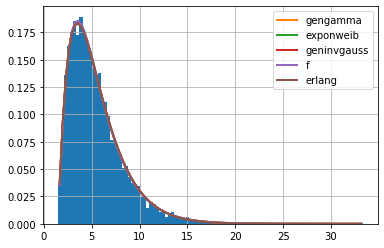

In [2]:
f.summary()

Initially the first curve is taken as it is considered the first best fitting curve and a command is set up using the summary index, or `eval("stats" + dist_df.index[0])` where `dist_df.index[0]` references the scipy curve, to create the random variable set. The parameters for the curve are obtained using the `.fitted_param` function which returns a dictionary whose keys match the summary index values.

Lastly, the `data_len` is taken as the same length of data is what is sought, the length of data created `r_len` is set of `0` and the value `run_once` is set to `False`.

In [3]:
# Return the best fitting curve to the data
dist_df = f.summary(Nbest=1, plot=False)

# Create a command for fitting the distribution 
dist = eval("stats." + dist_df.index[0])

# f.fitted_param gives the fitting characteristics of the different suggested curves.
params = f.fitted_param[dist_df.index[0]]

data_len = len(data)
r_len = 0

run_once = False

print(f"The best fitting curve is {dist_df.index[0]}")

The best fitting curve is gengamma


In order to match the lengths fo data a while loop is set to run with the condition where the length of data does not match the length of new data.

The distribution curves available in scipy can have inputs of 2, 3, or 4 values. A conditional `if` statment is set up to handle these cases and create the random variable set based on the curve. Being a random variable set without min/max conditions means the data created may have some odd values that don't fit within the parameters of the chosen data series. The data series created is then filtered down to have values that exist within the bounds of the original data's min/max values, but this drops values so the new dataset won't match the length of the old dataset. This keeps the while loop running and new data is gathered by calculating the difference between the current data length and the created data length, less the data outside the min/max. The second set of new values created are added to the first set of new values to make the new series the same length as the old series, to break the loop if the new series lies within the min/max bounds of the original data.   

In [4]:
# Probability
while data_len != r_len:
    dist_len = data_len - r_len
    if len(params) == 2:
        print("First condition")
        a, b = params
        r_tmp = pd.Series(dist.rvs(a, b, size = dist_len))

    elif len(params) == 3: 
        print("Second condition")
        a, b, c = params
        r_tmp = pd.Series(dist.rvs(a, b, c, size = dist_len))

    elif len(params) == 4:
        print(f"Third condition {data_len} - {r_len} = {dist_len}")
        a, b, c, d = params
        r_tmp = pd.Series(dist.rvs(a, b, c, d, size = dist_len))

    else:
        print(f"Tom, you're gonna need to make a condition for {dist_df.index[0]}")
        r = pd.Series([np.nan]*dist_len)

    if not run_once:
        run_once = True
        r = r_tmp
    else:
        print(r_tmp)
        r = r.append(r_tmp, ignore_index = True)

    r = r[(data.min() < r) & (r < data.max())]
    r_len = len(r)

Third condition 10000 - 0 = 10000


To compare the two distributions the plots of the two datasets can be made to show they're roughtly the same but the slight difference in peaks shows that they're not exactly the same.

Text(0.5, 1.0, 'Data Generated from gengamma')

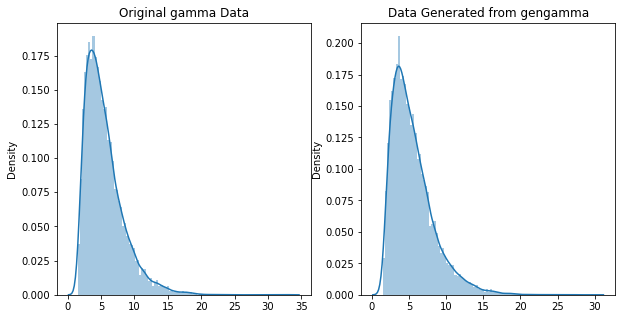

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig1 = plt.figure(figsize = (10, 5))
gs = fig1.add_gridspec(1, 2)

# Plot the distributed data and a random variate set based on the the selected curve distribution and compare side by side.
ax = fig1.add_subplot(gs[0,0])
sns.distplot(data, bins=100).set_title(f"Original gamma Data")
ax = fig1.add_subplot(gs[0,1])
sns.distplot(r, bins=100).set_title(f"Data Generated from {dist_df.index[0]}")


The process above is then set into a function to do the same process. 

Some of the issues found were that the method would loop looking for a suitable value so the `runs` variable was added to change the distribution curve and parameters if no suitable random variables can be found.

In [6]:
# From the testing above, create a function to do the same job
def create_random_set(data):
    data_len = len(data)
    data_min = data.min()
    data_max = data.max()
    
    # import and fit the dataset (series) that is to be randomised
    f = Fitter(data)
    f.fit()

    # Return the best fitting curve to the data
    dist_df = f.summary(plot=False)

    r_len = 0
    runs = 0
    # Probability
    while data_len != r_len:
        dist_len = data_len - r_len
        # f.fitted_param gives the fitting characteristics of the different suggested curves
        params = f.fitted_param[dist_df.index[runs]]
        dist = eval("stats." + dist_df.index[runs])

        if len(params) == 2:
            a, b = params
            r_tmp = pd.Series(dist.rvs(a, b, size = dist_len))

        elif len(params) == 3: 
            a, b, c = params
            r_tmp = pd.Series(dist.rvs(a, b, c, size = dist_len))

        elif len(params) == 4:
            a, b, c, d = params
            r_tmp = pd.Series(dist.rvs(a, b, c, d, size = dist_len))
            
        elif len(params) == 5:
            a, b, c, d, e = params
            r_tmp = pd.Series(dist.rvs(a, b, c, d, e, size = dist_len))
            
        elif len(params) == 6:
            a, b, c, d, e, f = params
            r_tmp = pd.Series(dist.rvs(a, b, c, d, e, f, size = dist_len))

        else:
            print(f"Tom, you're gonna need to make a condition for {dist_df.index[runs]}")
            r = pd.Series([np.nan]*dist_len)

        if r_len == 0:
            r = r_tmp.astype(np.int64)
        else:
            r = r.append(r_tmp.astype(np.int64), ignore_index = True)
            runs = runs + 1

        r = r[(data_min <= r) & (r <= data_max)]
        r_len = len(r)

    return r

# Use in a dataset

For testing purposes a dataset based on storm data was imported to a dataframe. In this data a series of storms are recorded with their `pressure`, `wind`, and `status` - either `Tropic Depression`, `Tropic Storm`, or `Hurricane`. The storm characteristics are seperated by their `name` and their `status` is defined by the `wind`. A more complex system could be created to define a relationship between `pressure`, `wind`, and `status` but this is merely an example of creating data and not an exercise in meteorolgy. 

Inhereted values might be important considerations to acknowledge when creating new data be it from financial or social media data that sets the base model.

The list of storms that are available are shown below:

In [7]:
storms = pd.read_csv('storms.csv')
storms['name'].unique()

array(['Amy', 'Caroline', 'Doris', 'Belle', 'Gloria', 'Anita', 'Clara',
       'Evelyn', 'Amelia', 'Bess', 'Cora', 'Juliet', 'Ana', 'Bob',
       'Claudette', 'David', 'Frederic', 'Henri', 'Bonnie', 'Charley',
       'Georges', 'Danielle', 'Hermine', 'Ivan', 'Jeanne', 'Karl',
       'Emily', 'Floyd', 'Gert', 'Harvey', 'Katrina', 'Alberto', 'Beryl',
       'Chris', 'Debby', 'Ernesto', 'Alicia', 'Barry', 'Chantal', 'Dean',
       'Arthur', 'Cesar', 'Diana', 'Edouard', 'Gustav', 'Hortense',
       'Isidore', 'Josephine', 'Klaus', 'Lili', 'Danny', 'Fabian',
       'Isabel', 'Juan', 'Kate', 'Andrew', 'AL031987', 'AL061988',
       'Gilbert', 'Isaac', 'Joan', 'Keith', 'Allison', 'Erin', 'Felix',
       'Gabrielle', 'Hugo', 'Iris', 'Jerry', 'Karen', 'Marco', 'Nana',
       'AL041991', 'Erika', 'AL101991', 'AL121991', 'AL021992',
       'AL031992', 'AL081992', 'AL011993', 'AL101993', 'AL021994',
       'AL051994', 'AL081994', 'AL091994', 'AL101994', 'Gordon',
       'AL061995', 'Humberto', 'Lu

And one is randomly selected for the test:

In [8]:
# Get a random storm from the list above that has more than 20 values for a good sample
storm_name = random.choice(storms['name'].unique())
storm_selected = storms[storms.name == storm_name]
while len(storm_selected) < 20:
    storm_name = random.choice(storms['name'].unique())
    storm_selected = storms[storms.name == storm_name]
storm_selected.head(10)

,name,year,month,day,hour,lat,long,status,category,wind,pressure,ts_diameter,hu_diameter
7963,Ike,2008,9,1,6,17.2,-37.0,tropical depression,-1,30,1006,0.0000,0.0
7964,Ike,2008,9,1,12,17.3,-38.4,tropical storm,0,35,1005,155.3553,0.0
7965,Ike,2008,9,1,18,17.5,-39.9,tropical storm,0,45,1003,212.8943,0.0
7966,Ike,2008,9,2,0,17.8,-41.3,tropical storm,0,45,1002,241.6638,0.0
7967,Ike,2008,9,2,6,18.2,-42.8,tropical storm,0,45,1000,276.1872,0.0
7968,Ike,2008,9,2,12,18.7,-44.3,tropical storm,0,50,999,276.1872,0.0
7969,Ike,2008,9,2,18,19.3,-45.8,tropical storm,0,55,996,276.1872,0.0
7970,Ike,2008,9,3,0,19.8,-47.3,tropical storm,0,55,994,270.4333,0.0
7971,Ike,2008,9,3,6,20.2,-48.8,tropical storm,0,55,992,264.6794,0.0
7972,Ike,2008,9,3,12,20.6,-50.3,tropical storm,0,60,989,258.9255,0.0


Since a storm is chosen by name and it is of `object` type, its column is superfluous to the current method and can be dropped from the set, while the other object columns are selected, particularly the `status` column.

A dataframe with selected columns is created and an empty dataframe with the same columns. A unique list of object variables is created with respect to the `status` column.

In [9]:
# Target columns for that are to be randomly generated
targ_col = ['wind', 'pressure']
# Basis column that has a parameter based on the target parameter.
col = 'status'
# Dataframe with just those columns
storms2 = storm_selected[targ_col + [col]]
# Blank dataframe with the columns that will be filled with the new storm values
new_storm = pd.DataFrame(columns = storms2.columns)
# The unique values of the status column
feat_col = storms2[col].unique() 

The dataframe is filtered for each of the details in the `status` column, and each of the target columns is fed into the `create_random_set` function above as a series so the function can fit to each of the target columns.

In [10]:
# For feature the status column is filtered. This will essentially 'groupby' the status and the target features  
# will not be a 'date/time' set (Having the status still structured as the original storm, the storm may still 
# be identifieable to the original) 

for feat in feat_col:
    # for each status value...
    storms_tmp = storms2[storms2[col] == feat]
    # create a dataframe same length as the the storm's 'status' value filled with the name and 'status' filled with the value
    new_storm_tmp = pd.DataFrame(data = {
        'name': [f'New {storm_name}']*len(storms_tmp),
        col: [feat]*len(storms_tmp)
    })
    for targ in targ_col:
        # For each of the target columns, run the function to generate a new dataset maybe better to use a '.map()' function.
        new_storm_tmp[targ] = create_random_set(storms_tmp[targ])
    # Append the generated data to the new dataset.
    new_storm = new_storm.append(new_storm_tmp, ignore_index = True)

# set the name value of storms2 and join the old and new datasets together for plotting 
storms2['name'] = storm_name
storms_joined = storms2.append(new_storm, ignore_index=True)

To show the similarities between the two datasets, a scatter plot is graphed showing the original storm and the new storm differentiated by colour, and the storm status defined by marker type.  

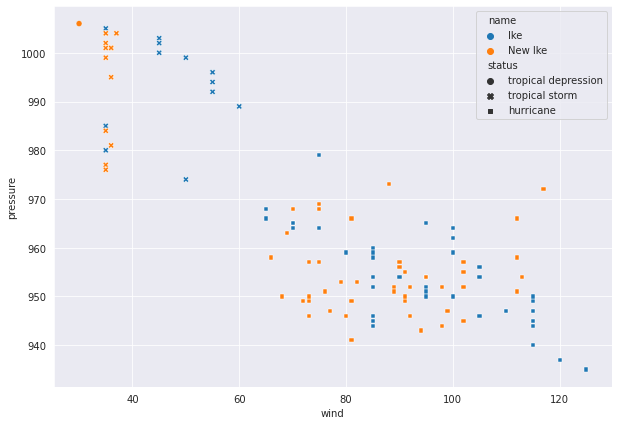

In [11]:
#Plot the two datasets together as a scatter comparing by colour and marker type of name and status.
fig2 = plt.figure(figsize=(10,7))
with sns.axes_style("darkgrid"):
    sns.scatterplot(data = storms_joined, x = "wind", y = "pressure", hue="name", style="status")

# Conclusions

Generally this seems to be a good method for developing an independent series of random data based on another series. It does not factor in correllating circumstances like a neural network might. How machine learning might be used in this manner is that the base characteristics should be identified, like in banking data the money in, and the secondary characteristics modelled based on historical data and desinging a neural network to calculate each column based on fundamental characteristics.

Some curves might not be suitable for the random data generation, like in the `tropic storm` generated data, the `pressure` dataset seems good but the corresponding `wind` distribution has poor variation. Similarly for the hurricane status there is a negative linear correlation between `pressure` and `wind` but in the new data there is low correlation.

In weather data, other fundamental characteristics might be global location (the longitude and lattitude) and the date/time series which aren't directly a result of the wind and pressure but a cause. The status of the storm is a direct result of the wind and pressure so it's category is based on